In [1]:
from datetime import datetime
import time

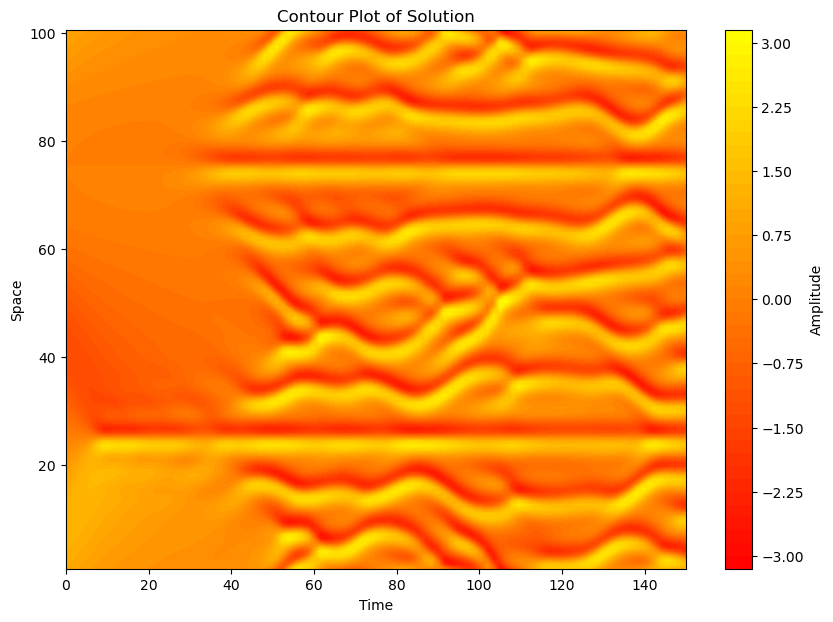

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Spatial grid and initial condition
N = 2**7
x = 32 * np.pi * np.arange(1, N+1) / N
u = np.cos(x/16) * (1 + np.sin(x/16))
v = np.fft.fft(u)

# Precompute various ETDRK4 scalar quantities
h = 1/4  # time step
k = np.concatenate([ np.arange(0, N//2), [0], np.arange(-N//2+1, 0)]) / 16  # wave numbers
L = k**2 - k**4  # Fourier multipliers
E = np.exp(h * L)
E2 = np.exp(h * L / 2)
M = 16  # number of points for complex means
r = np.exp(1j * np.pi * (np.arange(1, M+1) - 0.5) / M)  # roots of unity

LR = h * L[:, None] + r[None, :]
Q = h * np.real(np.mean((np.exp(LR / 2) - 1) / LR, axis=1))
f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3 * LR + LR**2)) / LR**3, axis=1))
f2 = h * np.real(np.mean((2 + LR + np.exp(LR) * (-2 + LR)) / LR**3, axis=1))
f3 = h * np.real(np.mean((-4 - 3 * LR - LR**2 + np.exp(LR) * (4 - LR)) / LR**3, axis=1))

# Main time-stepping loop
uu = u
tt = [0]
tmax = 150
nmax = round(tmax / h)
nplt = int(np.floor((tmax / 100) / h))
g = -0.5j * k





for n in range(1, nmax+1):
    t = n * h
    Nv = g * np.fft.fft(np.real(np.fft.ifft(v))**2)
    a = E2 * v + Q * Nv
    Na = g * np.fft.fft(np.real(np.fft.ifft(a))**2)
    b = E2 * v + Q * Na
    Nb = g * np.fft.fft(np.real(np.fft.ifft(b))**2)
    c = E2 * a + Q * (2 * Nb - Nv)
    Nc = g * np.fft.fft(np.real(np.fft.ifft(c))**2)
    
    v = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3
    
    if n % nplt == 0:
        u = np.real(np.fft.ifft(v))
        uu = np.vstack([uu, u])
        tt.append(t)

# Plot results using a contour plot
fig, ax = plt.subplots(figsize=(10, 7))
X, T = np.meshgrid(x, tt)
contour = ax.contourf(T, X, uu, levels=50, cmap=cm.autumn)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Amplitude')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_title('Contour Plot of Solution')

plt.show()


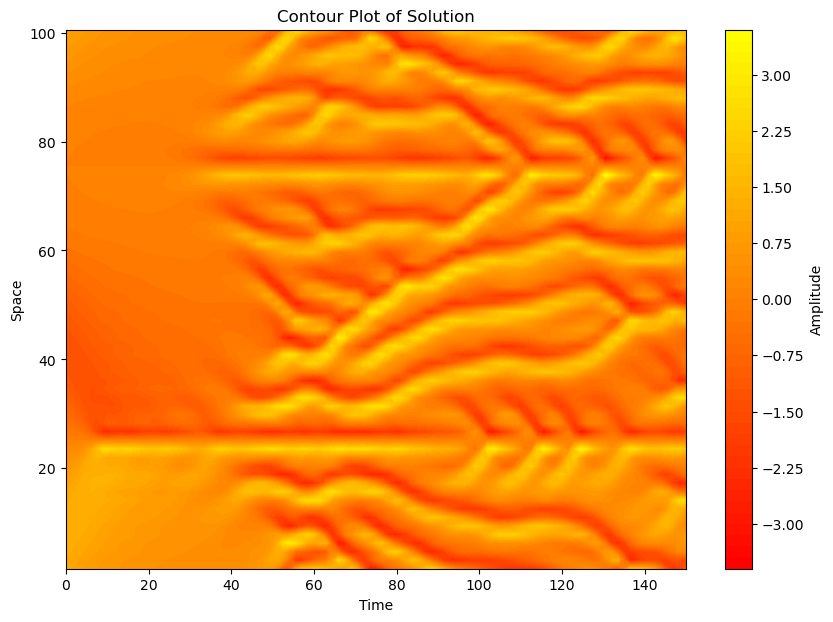

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Spatial grid and initial condition
N = 2**6
x = 32 * np.pi * np.arange(1, N+1) / N
u = np.cos(x/16) * (1 + np.sin(x/16))
v = np.fft.fft(u)

# Precompute various ETDRK4 scalar quantities
h = 1/4  # time step
k = np.concatenate([ np.arange(0, N//2), [0], np.arange(-N//2+1, 0)]) / 16  # wave numbers
L = k**2 - k**4  # Fourier multipliers
E = np.exp(h * L)
E2 = np.exp(h * L / 2)
M = 16  # number of points for complex means
r = np.exp(1j * np.pi * (np.arange(1, M+1) - 0.5) / M)  # roots of unity

LR = h * L[:, None] + r[None, :]
Q = h * np.real(np.mean((np.exp(LR / 2) - 1) / LR, axis=1))
f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3 * LR + LR**2)) / LR**3, axis=1))
f2 = h * np.real(np.mean((2 + LR + np.exp(LR) * (-2 + LR)) / LR**3, axis=1))
f3 = h * np.real(np.mean((-4 - 3 * LR - LR**2 + np.exp(LR) * (4 - LR)) / LR**3, axis=1))

# Main time-stepping loop
uu = u
tt = [0]
tmax = 150
nmax = round(tmax / h)
nplt = int(np.floor((tmax / 100) / h))
g = -0.5j * k





for n in range(1, nmax+1):
    t = n * h
    Nv = g * np.fft.fft(np.real(np.fft.ifft(v))**2)
    a = E2 * v + Q * Nv
    Na = g * np.fft.fft(np.real(np.fft.ifft(a))**2)
    b = E2 * v + Q * Na
    Nb = g * np.fft.fft(np.real(np.fft.ifft(b))**2)
    c = E2 * a + Q * (2 * Nb - Nv)
    Nc = g * np.fft.fft(np.real(np.fft.ifft(c))**2)
    
    v = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3
    
    if n % nplt == 0:
        u = np.real(np.fft.ifft(v))
        uu = np.vstack([uu, u])
        tt.append(t)

# Plot results using a contour plot
fig, ax = plt.subplots(figsize=(10, 7))
X, T = np.meshgrid(x, tt)
contour = ax.contourf(T, X, uu, levels=50, cmap=cm.autumn)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Amplitude')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_title('Contour Plot of Solution')

plt.show()


In [4]:
from matplotlib.animation import FuncAnimation, PillowWriter

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x, uu[0], color='blue')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(uu.min(), uu.max())
ax.set_xlabel('Space')
ax.set_ylabel('Amplitude')
ax.set_title('Change in Spatial Dimension Over Time')

# Update function for the animation
def update(frame):
    line.set_ydata(uu[frame])
    ax.set_title(f'Change in Spatial Dimension Over Time (t = {tt[frame]/20:.2f})')
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(tt), interval=50, blit=True)

# Save the animation as a GIF file
ani.save('spatial_dimension_over_time.gif', writer=PillowWriter(fps=20))

plt.close(fig)

In [5]:
def ks_equation(N):
    time_start = time.time()
    x = 32 * np.pi * np.arange(1, N+1) / N
    u = np.cos(x/16) * (1 + np.sin(x/16))
    v = np.fft.fft(u)

    # Precompute various ETDRK4 scalar quantities
    h = 1/4  # time step
    k = np.concatenate([ np.arange(0, N//2), [0], np.arange(-N//2+1, 0)]) / 16  # wave numbers
    L = k**2 - k**4  # Fourier multipliers
    E = np.exp(h * L)
    E2 = np.exp(h * L / 2)
    M = 16  # number of points for complex means
    r = np.exp(1j * np.pi * (np.arange(1, M+1) - 0.5) / M)  # roots of unity

    LR = h * L[:, None] + r[None, :]
    Q = h * np.real(np.mean((np.exp(LR / 2) - 1) / LR, axis=1))
    f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3 * LR + LR**2)) / LR**3, axis=1))
    f2 = h * np.real(np.mean((2 + LR + np.exp(LR) * (-2 + LR)) / LR**3, axis=1))
    f3 = h * np.real(np.mean((-4 - 3 * LR - LR**2 + np.exp(LR) * (4 - LR)) / LR**3, axis=1))

    # Main time-stepping loop
    uu = u
    tt = [0]
    tmax = 150
    nmax = round(tmax / h)
    nplt = int(np.floor((tmax / 100) / h))
    g = -0.5j * k





    for n in range(1, nmax+1):
        t = n * h
        Nv = g * np.fft.fft(np.real(np.fft.ifft(v))**2)
        a = E2 * v + Q * Nv
        Na = g * np.fft.fft(np.real(np.fft.ifft(a))**2)
        b = E2 * v + Q * Na
        Nb = g * np.fft.fft(np.real(np.fft.ifft(b))**2)
        c = E2 * a + Q * (2 * Nb - Nv)
        Nc = g * np.fft.fft(np.real(np.fft.ifft(c))**2)
        
        v = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3
        
        if n % nplt == 0:
            u = np.real(np.fft.ifft(v))
            uu = np.vstack([uu, u])
            tt.append(t)
    
    time_end = time.time()
    elapsed_time = time_end - time_start
    print(f"KS equation simulation completed in {elapsed_time:.2f} seconds.")
    
    
    return [x, tt, uu, elapsed_time]

In [6]:
Number_of_Spatial_Points = 2**np.arange(6,20,1)
time_elapsed_list = []
for N in Number_of_Spatial_Points:
    print(f"Running KS equation simulation for N = {N}...")
    x, tt, uu, elapsed_time = ks_equation(N)
    time_elapsed_list.append(elapsed_time) 
    


Running KS equation simulation for N = 64...
KS equation simulation completed in 0.13 seconds.
Running KS equation simulation for N = 128...
KS equation simulation completed in 0.14 seconds.
Running KS equation simulation for N = 256...
KS equation simulation completed in 0.16 seconds.
Running KS equation simulation for N = 512...
KS equation simulation completed in 0.21 seconds.
Running KS equation simulation for N = 1024...
KS equation simulation completed in 0.25 seconds.
Running KS equation simulation for N = 2048...
KS equation simulation completed in 0.49 seconds.
Running KS equation simulation for N = 4096...
KS equation simulation completed in 0.83 seconds.
Running KS equation simulation for N = 8192...
KS equation simulation completed in 1.52 seconds.
Running KS equation simulation for N = 16384...
KS equation simulation completed in 2.96 seconds.
Running KS equation simulation for N = 32768...


KeyboardInterrupt: 

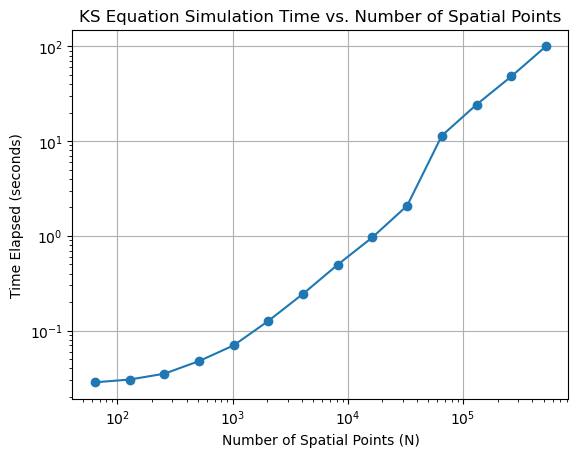

In [ ]:
plt.loglog(Number_of_Spatial_Points, time_elapsed_list, marker='o')
plt.xlabel('Number of Spatial Points (N)')
plt.ylabel('Time Elapsed (seconds)')
plt.title('KS Equation Simulation Time vs. Number of Spatial Points')
plt.grid(True)
plt.show()

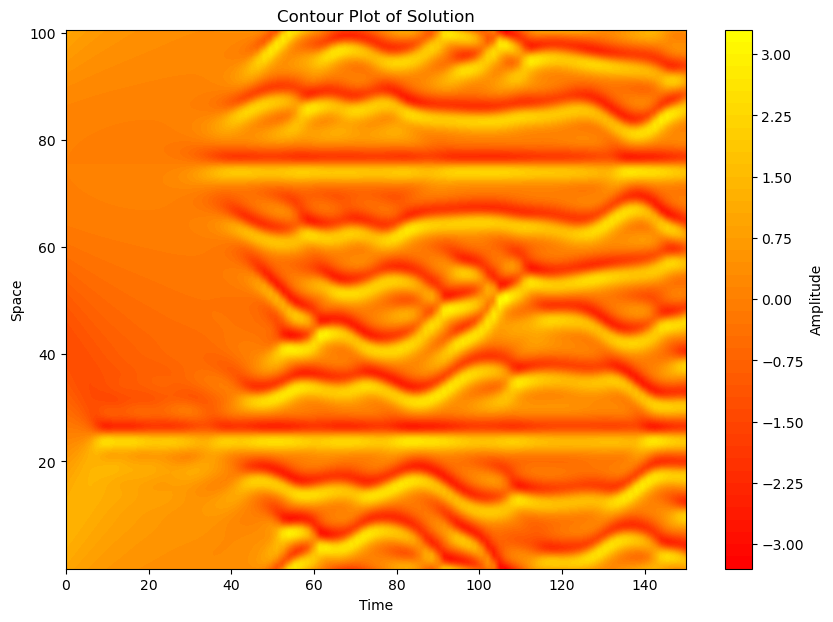

In [13]:
## checking convergence rate of ETDRK4 scheme
## High accuracy solution for refrence N = 2**19
Test_solution = ks_equation(2**10)

KS equation simulation completed in 0.23 seconds.


In [ ]:
np.arange(6,19,1)

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [11]:
Number_of_Spatial_Points = 2**np.arange(6,10,1)
Solutions_list = []

for N in Number_of_Spatial_Points:
    print(f"Computing solution for N = {N}...")
    x, tt, uu, elapsed_time = ks_equation(N)
    Solutions_list.append(uu)
    
    


Computing solution for N = 64...
KS equation simulation completed in 0.11 seconds.
Computing solution for N = 128...
KS equation simulation completed in 0.14 seconds.
Computing solution for N = 256...
KS equation simulation completed in 0.15 seconds.
Computing solution for N = 512...
KS equation simulation completed in 0.19 seconds.


In [15]:
## taking the l2 norm of the relative difference between solutions
Errors = []
for i, N in enumerate(Number_of_Spatial_Points):
    Current_Order_points = i + 6
    Highest_Order_Points = 10
    index = Highest_Order_Points - Current_Order_points
    
    Standard_solution = Test_solution[2][:,2**index-1::2**index]
    
    
    diff = Solutions_list[i] - Standard_solution
    error = np.linalg.norm(diff)/np.linalg.norm(Standard_solution)
    Errors.append(error)

In [16]:
Test_solution[2][:,2**(19-6)-1::2**(19-6)].shape

(101, 0)

In [17]:
x = Test_solution[0]

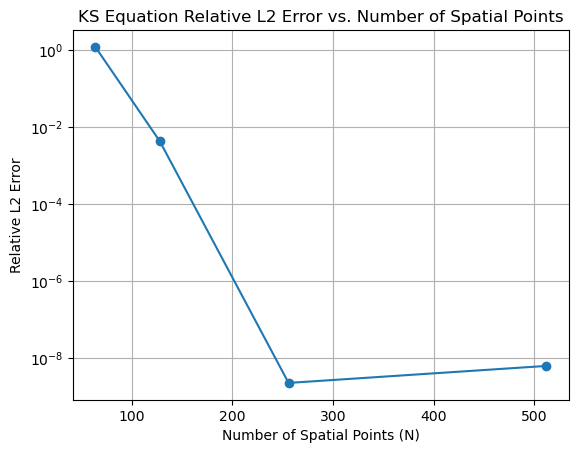

In [18]:
##plotting the errors
plt.semilogy(Number_of_Spatial_Points, Errors, marker='o')
plt.xlabel('Number of Spatial Points (N)')
plt.ylabel('Relative L2 Error')
plt.title('KS Equation Relative L2 Error vs. Number of Spatial Points')
plt.grid(True)
plt.show()

In [ ]:
def x_coords(N):
    return 32 * np.pi * np.arange(1, N+1) / N

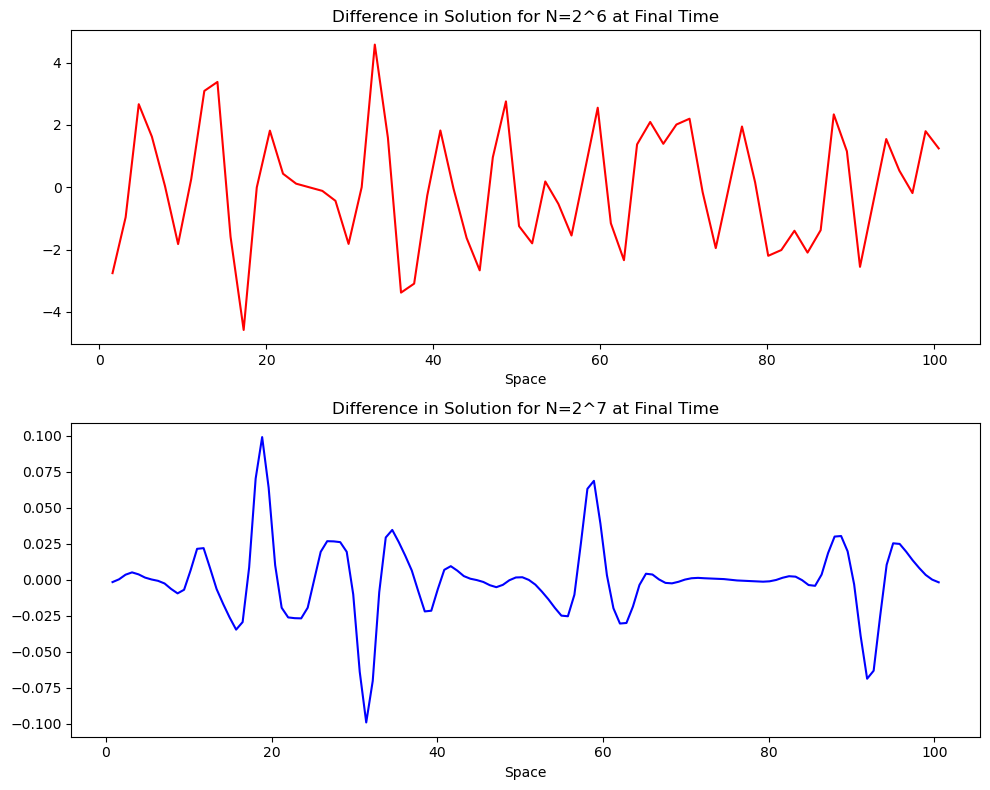

In [ ]:
##plotting difference for N = 2**6 and N = 2**7
diff_6 = Solutions_list[0] - Test_solution[2][:,2**(19-6)-1::2**(19-6)]
diff_7 = Solutions_list[1] - Test_solution[2][:,2**(19-7)-1::2**(19-7)]
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(x_coords(2**6), diff_6[-1], color='red')
ax[0].set_title('Error in KS Solution for N=2^6 at Final Time')
ax[0].set_xlabel('Space')
ax[1].plot(x_coords(2**7), diff_7[-1], color='blue')
ax[1].set_title('Error in KS Solution for N=2^7 at Final Time')
ax[1].set_xlabel('Space')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
x = x_coords(2**6)

line1, = ax.plot(x, Solutions_list[0][0], color='blue',label='N=2^6 Solution')
line2, = ax.plot(x, Solutions_list[1][0,1::2], color='orange',label='N=2^7 Solution')
line3, = ax.plot(x, Test_solution[2][0,2**(19-6)-1::2**(19-6)], color='green', linestyle='dashed',label='N=2^19 Reference Solution')

ax.set_xlim(x.min(), x.max())
ax.set_ylim(min(Solutions_list[0].min(), Solutions_list[1].min(), Test_solution[2].min()),
             max(Solutions_list[0].max(), Solutions_list[1].max(), Test_solution[2].max()))
ax.set_xlabel('Space')
ax.set_ylabel('Amplitude')
ax.set_title('KS Equation Solutions Comparison Low Spectral Fidelity')


plt.legend(loc='upper right')

# Update function for the animation
def update(frame):
    line1.set_ydata(Solutions_list[0][frame])
    line2.set_ydata(Solutions_list[1][frame,1::2])
    line3.set_ydata(Test_solution[2][frame,2**(19-6)-1::2**(19-6)])
    ax.set_title(f'KS Equation Solutions Comparison Low Spectral Fidelity (t = {tt[frame]/20:.2f})')
    return line1, line2, line3,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(tt), interval=50, blit=True)

# Save the animation as a GIF file
ani.save('KS_EQ_comparisons_lowspectralfidelity.gif', writer=PillowWriter(fps=20))

plt.close(fig)

In [ ]:
##creating a higher spectral fidelity comparison animation N=2**11 vs N=2**12

fig, ax = plt.subplots(figsize=(10, 6))
x = x_coords(2**11)

line1, = ax.plot(x, Solutions_list[5][0], color='blue',label='N=2^11 Solution')
line2, = ax.plot(x, Solutions_list[6][0,1::2], color='orange',label='N=2^12 Solution')
line3, = ax.plot(x, Test_solution[2][0,2**(19-11)-1::2**(19-11)], color='green', linestyle='dashed',label='N=2^19 Reference Solution')

ax.set_xlim(x.min(), x.max())
ax.set_ylim(min(Solutions_list[0].min(), Solutions_list[1].min(), Test_solution[2].min()),
             max(Solutions_list[0].max(), Solutions_list[1].max(), Test_solution[2].max()))
ax.set_xlabel('Space')
ax.set_ylabel('Amplitude')
ax.set_title('KS Equation Solutions Comparison High Spectral Fidelity')


plt.legend(loc='upper right')

# Update function for the animation
def update(frame):
    line1.set_ydata(Solutions_list[5][frame])
    line2.set_ydata(Solutions_list[6][frame,1::2])
    line3.set_ydata(Test_solution[2][frame,2**(19-11)-1::2**(19-11)])
    ax.set_title(f'KS Equation Solutions Comparison High Spectral Fidelity (t = {tt[frame]/20:.2f})')
    return line1, line2, line3,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(tt), interval=50, blit=True)

# Save the animation as a GIF file
ani.save('KS_EQ_comparisons_highspectralfidelity.gif', writer=PillowWriter(fps=20))

plt.close(fig)

In [ ]:
x.size

2048